In [1]:
# Задание из лекции 10:
# Сгенерируйте набор данных для предсказания временных #последовательностей. Выполните тренировку RNN
# Модифицируйте сеть, используя в качестве рекуррентного слоя LSTM слой #библиотеки pytorch.
#https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


# Генерация набора данных временных последовательностей
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        # Данные и длина последовательности
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        # Длина датасета
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        # Извлекаем последовательность x и следующий за ней элемент y
        x = self.data[index:index + self.seq_length]
        y = self.data[index + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    

# Определение модели RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size  # Размер скрытого слоя
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)  # RNN слой
        self.fc = nn.Linear(hidden_size, output_size)  # Полносвязный слой для предсказания

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])

        return out
    
# Модифицированная модель с LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Инициализация скрытого состояния и состояния ячейки нулями
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out
    
# Создаем синусоидальный набор данных с шумом
seq_length = 20  # Длина временной последовательности
n_samples = 1000  # Общее количество точек
x = np.linspace(0, 100, n_samples)
data = np.sin(x) + 0.1 * np.random.normal(size=len(x))  # Синусоида с шумом

# Разделение данных на тренировочный и тестовый наборы
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Создаем датасеты и загрузчики данных
train_dataset = TimeSeriesDataset(train_data, seq_length)
test_dataset = TimeSeriesDataset(test_data, seq_length)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Тренировочный загрузчик
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)   # Тестовый загрузчик

input_size = 1
hidden_size = 50
output_size = 1

def train_model(model, dataloader, epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.view(-1, seq_length, input_size)
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()

        print(f"Эпоха [{epoch+1}/{epochs}], Потери: {loss.item():.4f}")


print("Обучение RNN")
rnn_model = RNN(input_size, hidden_size, output_size)
train_model(rnn_model, train_dataloader, epochs=20)

Обучение RNN
Эпоха [1/20], Потери: 0.0760
Эпоха [2/20], Потери: 0.0289
Эпоха [3/20], Потери: 0.0122
Эпоха [4/20], Потери: 0.0206
Эпоха [5/20], Потери: 0.0188
Эпоха [6/20], Потери: 0.0234
Эпоха [7/20], Потери: 0.0181
Эпоха [8/20], Потери: 0.0098
Эпоха [9/20], Потери: 0.0258
Эпоха [10/20], Потери: 0.0125
Эпоха [11/20], Потери: 0.0071
Эпоха [12/20], Потери: 0.0214
Эпоха [13/20], Потери: 0.0111
Эпоха [14/20], Потери: 0.0211
Эпоха [15/20], Потери: 0.0131
Эпоха [16/20], Потери: 0.0107
Эпоха [17/20], Потери: 0.0125
Эпоха [18/20], Потери: 0.0114
Эпоха [19/20], Потери: 0.0122
Эпоха [20/20], Потери: 0.0196


In [2]:
print("Обучение LSTM")
lstm_model = LSTM(input_size, hidden_size, output_size)
train_model(lstm_model, train_dataloader, epochs=20)

Обучение LSTM
Эпоха [1/20], Потери: 0.2510
Эпоха [2/20], Потери: 0.0830
Эпоха [3/20], Потери: 0.0208
Эпоха [4/20], Потери: 0.0356
Эпоха [5/20], Потери: 0.0210
Эпоха [6/20], Потери: 0.0066
Эпоха [7/20], Потери: 0.0229
Эпоха [8/20], Потери: 0.0131
Эпоха [9/20], Потери: 0.0102
Эпоха [10/20], Потери: 0.0156
Эпоха [11/20], Потери: 0.0162
Эпоха [12/20], Потери: 0.0201
Эпоха [13/20], Потери: 0.0049
Эпоха [14/20], Потери: 0.0122
Эпоха [15/20], Потери: 0.0099
Эпоха [16/20], Потери: 0.0129
Эпоха [17/20], Потери: 0.0063
Эпоха [18/20], Потери: 0.0173
Эпоха [19/20], Потери: 0.0119
Эпоха [20/20], Потери: 0.0126


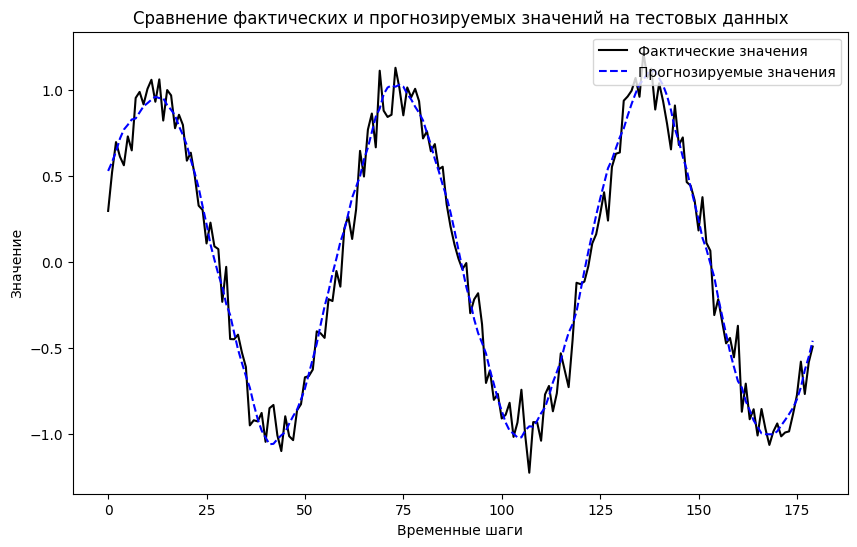

In [4]:
# Проверка модели на тестовом наборе данных
model = lstm_model
model.eval()
predictions = []
actual = []

with torch.no_grad():
    for x, y in test_dataloader:
        x = x.view(1, seq_length, input_size)
        pred = model(x).item()
        predictions.append(pred)
        actual.append(y.item())

plt.figure(figsize=(10, 6))
plt.plot(actual, label="Фактические значения", linestyle='-', color='black')
plt.plot(predictions, label="Прогнозируемые значения", linestyle='--', color='blue')
plt.legend(loc='upper right')
plt.xlabel("Временные шаги")
plt.ylabel("Значение")
plt.title("Сравнение фактических и прогнозируемых значений на тестовых данных")
plt.show()

In [5]:
# Задание из лекции 7:
# Разделить данные на N групп. (возможно, выбрать первые M данных для обучения)
# Реализовать предсказание ARIMA для 2 (тренировочной группы) на основе 1. Рассчитать MSE.
# Исследовать качество работы модели в зависимости от параметров (для групп 1-2).
# Выполнить итеративное предсказание, данные для каждого следующего предсказания обновлять по методу "экспоненциальное среднее".

# Загрузка данных
df = pd.read_csv('ETTm1.csv')

# Разделяем данные на N групп
N = 2
dfs = np.array_split(df, N)

# Данные первой группы для обучения, второй для тестирования
train = dfs[0]['OT']
test = dfs[1]['OT']

# Строим модель ARIMA для тренировочных данных
model = ARIMA(train, order=(3, 0, 0))
model_fit = model.fit()

# Прогнозируем значения на длину тестового набора
predictions = model_fit.forecast(steps=len(test))

# Вычисляем среднеквадратическую ошибку (MSE)
mse = mean_squared_error(test, predictions)
print(f'Среднеквадратическая ошибка (MSE): {mse:.4f}')

c:\Users\Kristofer\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Среднеквадратическая ошибка (MSE): 92.3683


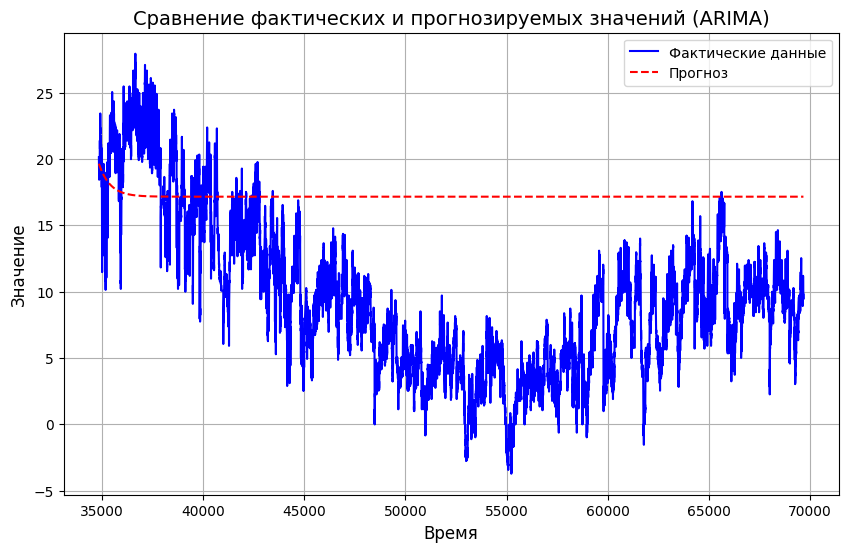

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Фактические данные', color='blue')
plt.plot(test.index, predictions, label='Прогноз', color='red', linestyle='--')
plt.title('Сравнение фактических и прогнозируемых значений (ARIMA)', fontsize=14)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [7]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

# Параметры для исследования (p, d, q)
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

results = []
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Строим модель ARIMA для текущих значений параметров (p, d, q)
                model = ARIMA(train, order=(p, d, q))
                model_fit = model.fit()

                # Прогнозируем значения на длину тестового набора
                predictions = model_fit.forecast(steps=len(test))

                mse = mean_squared_error(test, predictions)

                print(f'Параметры (p={p}, d={d}, q={q}): MSE = {mse:.4f}')

                results.append((p, d, q, mse))

            except Exception as e:
                print(f"Ошибка с параметрами (p={p}, d={d}, q={q}): {e}")

results_df = pd.DataFrame(results, columns=['p', 'd', 'q', 'MSE'])

best_params = results_df.loc[results_df['MSE'].idxmin()]

Параметры (p=0, d=0, q=0): MSE = 92.5003
Параметры (p=0, d=0, q=1): MSE = 92.5052
Параметры (p=0, d=0, q=2): MSE = 92.5072
Параметры (p=0, d=0, q=3): MSE = 92.5043
Параметры (p=0, d=1, q=0): MSE = 136.5504
Параметры (p=0, d=1, q=1): MSE = 136.6108
Параметры (p=0, d=1, q=2): MSE = 136.7757
Параметры (p=0, d=1, q=3): MSE = 136.9788
Параметры (p=1, d=0, q=0): MSE = 92.3473
Параметры (p=1, d=0, q=1): MSE = 92.3802
Параметры (p=1, d=0, q=2): MSE = 92.3691
Параметры (p=1, d=0, q=3): MSE = 92.3647
Параметры (p=1, d=1, q=0): MSE = 136.5504
Параметры (p=1, d=1, q=1): MSE = 136.6722
Параметры (p=1, d=1, q=2): MSE = 137.2087
Параметры (p=1, d=1, q=3): MSE = 137.2522
Параметры (p=2, d=0, q=0): MSE = 92.3821
Параметры (p=2, d=0, q=1): MSE = 92.4083
Параметры (p=2, d=0, q=2): MSE = 92.3626
Параметры (p=2, d=0, q=3): MSE = 92.3538
Параметры (p=2, d=1, q=0): MSE = 136.8627
Параметры (p=2, d=1, q=1): MSE = 136.9923
Параметры (p=2, d=1, q=2): MSE = 137.2174
Параметры (p=2, d=1, q=3): MSE = 137.2103
Пара

In [10]:
print(f'Лучшие параметры: p={best_params["p"]}, d={best_params["d"]}, q={best_params["q"]}')
print(f'Соответствующая MSE: {best_params["MSE"]:.4f}')

results_df_sorted = results_df.sort_values(by='MSE')
print("\nТаблица с результатами (сортировка по MSE):")
print(results_df_sorted)

Лучшие параметры: p=1.0, d=0.0, q=0.0
Соответствующая MSE: 92.3473

Таблица с результатами (сортировка по MSE):
    p  d  q         MSE
8   1  0  0   92.347272
19  2  0  3   92.353829
18  2  0  2   92.362573
11  1  0  3   92.364671
24  3  0  0   92.368328
10  1  0  2   92.369144
26  3  0  2   92.378767
9   1  0  1   92.380187
16  2  0  0   92.382107
27  3  0  3   92.407072
17  2  0  1   92.408290
25  3  0  1   92.425806
0   0  0  0   92.500254
3   0  0  3   92.504298
1   0  0  1   92.505160
2   0  0  2   92.507197
4   0  1  0  136.550396
12  1  1  0  136.550396
5   0  1  1  136.610809
13  1  1  1  136.672179
6   0  1  2  136.775680
20  2  1  0  136.862707
29  3  1  1  136.965974
28  3  1  0  136.971305
7   0  1  3  136.978773
21  2  1  1  136.992284
30  3  1  2  137.150951
14  1  1  2  137.208699
23  2  1  3  137.210265
22  2  1  2  137.217358
15  1  1  3  137.252153
31  3  1  3  137.432285


In [11]:
alpha = 0.5  # Коэффициент сглаживания

model = ARIMA(train, order=(1, 0, 0)).fit()

predictions = []
current_prediction = model.forecast(steps=1).iloc[0]

for true_value in test:
    predictions.append(current_prediction)
    current_prediction = alpha * true_value + (1 - alpha) * current_prediction

mse = mean_squared_error(test, predictions)
print(f'Среднеквадратическая ошибка (итерационная с экспоненциальным сглаживанием): {mse:.4f}')

Среднеквадратическая ошибка (итерационная с экспоненциальным сглаживанием): 0.1806
